In [1]:
# Import all the required Libraries

import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import networkx as nx
import math
import csv
import matplotlib.pylab as pyl
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read all the event files of all the leagues
events=[]
leagues = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for league in leagues:
    events.append(pd.read_json('dataset\events\events_%s.json' %league))

In [3]:
# Read all the matches in all the leagues
matches=[]
leagues = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for match in leagues:
    matches.append(pd.read_json('dataset\matches\matches_%s.json' %match))

In [4]:
# Read required input files

player_df = pd.read_json("dataset\players.json")
team_data_df = pd.read_json("dataset/teams.json") 





In [5]:
# Data Preprocessing

# Conversion of special character into normal character in players name

def jsonparse(x):
    s = '"'+x+'"'
    s = s.replace('	', '')
    return json.loads(s.replace('	', ''))

player_df['shortName'] = player_df['shortName'].map(lambda x: jsonparse(x))


# Addition of a player name based on player id in the event dataframe

a=player_df[['wyId','shortName']]    # Selecting the player name from player dataframe

for event in events:    
    b=event[['playerId']]             # Selecting the playerId from the event dataframe
    c=b.merge(a,how='left', left_on='playerId', right_on='wyId')  # Merging both the dataframe
    event["player"] = c.shortName           # Addition of the player name in the event dataframe



In [6]:
def passing_network(event_df, match_df, match_Id):
    
   
   
    prev = 0
    
    
   
    match_description = match_df.label.values[0] 
    
     # Altering the time of the event in the second half by adding the maximum time of the first half
    
    first_half_max_duration = np.max(event_df[event_df['matchPeriod'] == '1H']['eventSec'])
    event_df.loc[event_df.matchPeriod == "2H", "eventSec"] = event_df[event_df.matchPeriod == '2H'].eventSec  + first_half_max_duration 
   
    

    event_df_pass = event_df[(event_df.matchId==match_Id) & (event_df.eventName == 'Pass')]
    
           
    team_id=event_df_pass.teamId.unique()
    
    
    winner = match_df.winner[match_df['wyId'] == match_Id].values[0]
    
    if winner == team_id[0]:
        Winner = "Team_1"
    else:
        if winner == team_id[1]:
             Winner = "Team_2"
        else:
             Winner = "Draw" 

    team1_name = team_data_df.name[team_data_df['wyId']==team_id[0]].values[0]
    team2_name = team_data_df.name[team_data_df['wyId']==team_id[1]].values[0]
   
    Teams_Played = team1_name + '-' + team2_name
 # Filtering the passing events
    
    for time in range(15*60,(90*60)+1,15*60):
        team_temp_list = []
        if time != (90*60) :        
            temp_pass_df = event_df_pass[(event_df.eventSec < time) & (event_df.eventSec > prev)] 
            temp_pass_df = temp_pass_df.dropna(how='any',axis=0)     
        else:
            temp_pass_df = event_df_pass[(event_df.eventSec > prev)] 
            temp_pass_df = temp_pass_df.dropna(how='any',axis=0)         
           
            
        
        # Seperation of the passess 
        team1_pass_events = temp_pass_df[temp_pass_df['teamId'] == team_id[0]]
        team2_pass_events = temp_pass_df[temp_pass_df['teamId'] == team_id[1]]     

        team_1 = pd.DataFrame()

        team_1['sender'] = team1_pass_events.player
        team_1['receiver'] = team1_pass_events.player.shift(-1).dropna()

        team_2 = pd.DataFrame()
        team_2['sender'] = team2_pass_events.player
        team_2['receiver'] = team2_pass_events.player.shift(-1).dropna()        

        df_team1 = []
        for i,row in team_1.iterrows():
            if row['sender'] == row['receiver']:
                pass        
            else:
                df_team1.append([row['sender'],row['receiver']])
        df_team1 = pd.DataFrame(df_team1, columns=['sender','receiver']) 

        # Dataframe with total number of passess between two player of team 1
        df_team1_count = df_team1.groupby(['sender','receiver']).size().reset_index(name="No_of_Passes")



        # Total number of passess in team 1 

        team1_total_passes = df_team1_count.No_of_Passes.sum()     





        # create dataframe of sender and receiver with number of passes for team 2

        df_team2 = []
        for i,row in team_2.iterrows():
            if row['sender'] == row['receiver']:
                pass        
            else:
                df_team2.append([row['sender'],row['receiver']])
        df_team2 = pd.DataFrame(df_team2, columns=['sender','receiver']) 

        # Dataframe with total number of passess between two player of team 2
        df_team2_count = df_team2.groupby(['sender','receiver']).size().reset_index(name="No_of_Passes")

        # Total number of passess in team 2 

        team2_total_passes = df_team2_count.No_of_Passes.sum()  




        # Calculation of position of the player for team 1   

        pos1 = {}
        actual_pos1 = {}
        pos1_relative = {}  # Position of the player with respect to football pitch layout


        for player in list(df_team1['sender'].unique()):
            x, y = [], []
            df_match_player = temp_pass_df[temp_pass_df.player==player]
            for i,row in df_match_player.iterrows():
                x.append(row['positions'][0]['x'])            
                y.append(row['positions'][0]['y'])

            # Mean position of the player
            actual_pos1[player] = (int(np.mean(x)), int(np.mean(y)))
            pos1[player] = (int(105 - np.mean(x)), int(69-(np.mean(y))))
            pos1_relative[(player)] = (int(105 - np.mean(x)), int(69-(np.mean(y)/100 * 69)))




        # Calculation of the average possession position of the team 1
        pos1_df =  pd.DataFrame(actual_pos1).T.reset_index()
        pos1_df.columns = ['Player','X','Y']

        team1_possession_mean_x = pos1_df["X"].mean()
        team1_possession_mean_y = pos1_df["Y"].mean()




        # Calculation of position of the player for team 2  

        pos2 = {}
        actual_pos2 = {}
        pos2_relative = {}  # Position of the player with respect to football pitch layout

        for player in list(df_team2['sender'].unique()):
            x, y = [], []
            df_match_player = temp_pass_df[temp_pass_df.player==player]
            for i,row in df_match_player.iterrows():
                x.append(row['positions'][0]['x'])
                y.append(row['positions'][0]['y'])

            # Mean position of the players during the match

            actual_pos2[player] = (int(np.mean(x)), int(np.mean(y)))
            pos2[(player)] = (int(np.mean(x)), int(np.mean(y)))        
            pos2_relative[(player)] = (int(np.mean(x)), int(np.mean(y)/100 * 69))



         # Calculation of the average possession position of the team 2
        pos2_df =  pd.DataFrame(actual_pos2).T.reset_index()
        pos2_df.columns = ['Player','X','Y']

        team2_possession_mean_x = pos2_df["X"].mean()
        team2_possession_mean_y = pos2_df["Y"].mean()   



      # Passing Network for the team 1

        g = nx.Graph()
        for i,row in df_team1_count.iterrows():
            g.add_edge(row['sender'],row['receiver'],weight=row['No_of_Passes'])
        deg = dict(g.degree)
        team1_degree = 0
        for player_deg in deg.values():
            team1_degree = team1_degree + player_deg

        team1_centrality = round(nx.global_reaching_centrality(g),2)
        team1_avg_clustering = round(nx.average_clustering(g),2)
        team1_connectivity = round(nx.algebraic_connectivity(g),2)
        team1_density = round(nx.density(g),2)
        team1_diameter = nx.diameter(g)
        team1_asp = round(nx.average_shortest_path_length(g),2)



        if (match_Id == 2499954) | (match_Id == 2499943) : 
            nx.draw(g, pos1, with_labels=True, node_size=[v * 100 for v in deg.values()], font_size=10, font_weight='normal')
            nx.write_gexf(g, "team_1.gexf")
            plt.title(team1_name, fontsize=20)
            plt.show()
            print (team1_name)
            print('Degree =',team1_degree)
            print ('Centrality =', round(nx.global_reaching_centrality(g),2))
            print ('Clustering =', round(nx.average_clustering(g),2))
            print ('Algebric connectivity =', round(nx.algebraic_connectivity(g),2))
            print ('Density =', round(nx.density(g),2))
            print ('Diameter =', nx.diameter(g))
            print ('Average Path Length =', round(nx.average_shortest_path_length(g),2))

            print ('')

        # Passing Network for the team 2

        r = nx.Graph()
        for i,row in df_team2_count.iterrows():
            r.add_edge(row['sender'],row['receiver'],weight=row['No_of_Passes'])
        deg = dict(r.degree)
        team2_degree = 0
        for player_deg in deg.values():
            team2_degree = team2_degree + player_deg

        team2_centrality = round(nx.global_reaching_centrality(r),2)
        team2_avg_clustering = round(nx.average_clustering(r),2)
        team2_connectivity =round(nx.algebraic_connectivity(r),2)
        team2_density = round(nx.density(r),2)
        team2_diameter = nx.diameter(r)
        team2_asp = round(nx.average_shortest_path_length(r),2)



        if (match_Id == 2499954) | (match_Id == 2499943) :  
            nx.draw(r, pos2, node_color='r', node_size=[v * 100 for v in deg.values()],with_labels=True, font_size=10, font_weight='normal')
            nx.write_gexf(r, "team_2.gexf")
            plt.title(team2_name, fontsize=20)
            plt.show()

            print (team2_name)
            print('Degree =',team2_degree)        
            print ('Centrality =', round(nx.global_reaching_centrality(r),2))
            print ('Clustering =', round(nx.average_clustering(r),2))
            print ('Algebric connectivity =', round(nx.algebraic_connectivity(r),2))
            print ('Density =', round(nx.density(r),2))
            print ('Diameter =', nx.diameter(r))
            print ('Average Path Length =', round(nx.average_shortest_path_length(r),2))


        # Append all the features in the original list

        team_temp_list.append(match_Id)
        team_temp_list.append(Teams_Played)                                      
        team_temp_list.append(team1_name)
        team_temp_list.append(team2_name)
        team_temp_list.append(team1_total_passes)
        team_temp_list.append(team2_total_passes)
        team_temp_list.append(round(team1_possession_mean_x,2))
        team_temp_list.append(round(team1_possession_mean_y,2))
        team_temp_list.append(round(team2_possession_mean_x,2))
        team_temp_list.append(round(team2_possession_mean_y,2))
        team_temp_list.append(team1_degree)
        team_temp_list.append(team2_degree)
        team_temp_list.append(team1_centrality)
        team_temp_list.append(team2_centrality)
        team_temp_list.append(team1_avg_clustering)
        team_temp_list.append(team2_avg_clustering)
        team_temp_list.append(team1_connectivity)
        team_temp_list.append(team2_connectivity)
        team_temp_list.append(team1_density)
        team_temp_list.append(team2_density) 
        team_temp_list.append(team1_diameter)
        team_temp_list.append(team2_diameter)
        team_temp_list.append(team1_asp)
        team_temp_list.append(team2_asp)

    

      
        teams_metrics_list.append(team_temp_list)
        
        prev=time
    Total_Winner.append(Winner)

    
    
    


In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

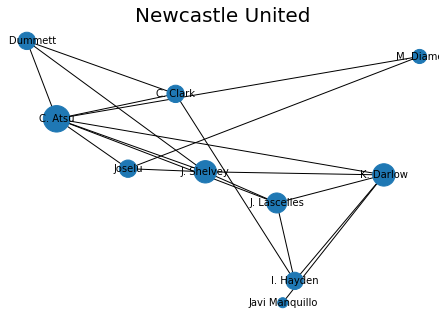

Newcastle United
Degree = 36
Centrality = 0.23
Clustering = 0.49
Algebric connectivity = 0.84
Density = 0.4
Diameter = 3
Average Path Length = 1.73



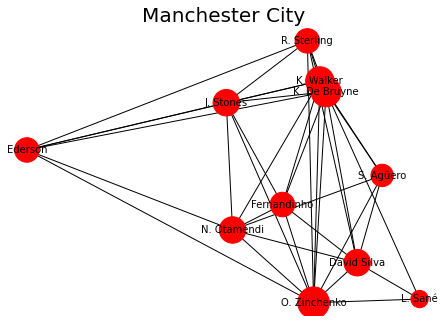

Manchester City
Degree = 74
Centrality = 0.18
Clustering = 0.75
Algebric connectivity = 5.2
Density = 0.67
Diameter = 2
Average Path Length = 1.33


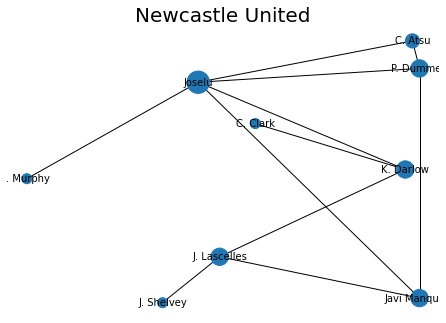

Newcastle United
Degree = 22
Centrality = 0.22
Clustering = 0.24
Algebric connectivity = 0.54
Density = 0.31
Diameter = 4
Average Path Length = 2.06



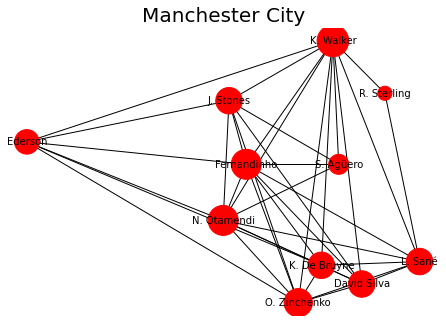

Manchester City
Degree = 76
Centrality = 0.17
Clustering = 0.84
Algebric connectivity = 2.05
Density = 0.69
Diameter = 2
Average Path Length = 1.31


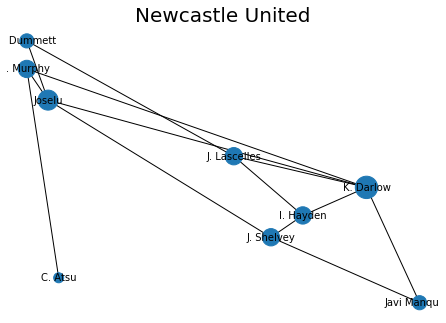

Newcastle United
Degree = 26
Centrality = 0.18
Clustering = 0.15
Algebric connectivity = 0.65
Density = 0.36
Diameter = 3
Average Path Length = 1.81



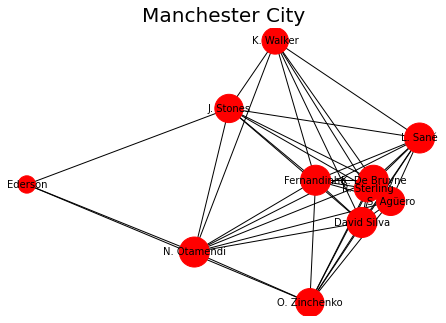

Manchester City
Degree = 86
Centrality = 0.06
Clustering = 0.82
Algebric connectivity = 3.08
Density = 0.78
Diameter = 2
Average Path Length = 1.22


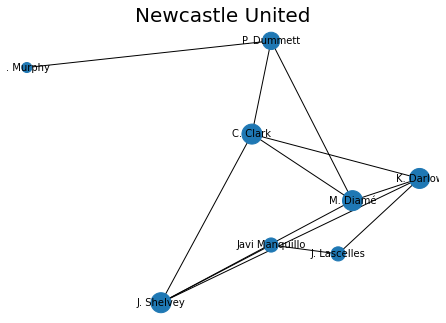

Newcastle United
Degree = 24
Centrality = 0.13
Clustering = 0.33
Algebric connectivity = 0.59
Density = 0.43
Diameter = 4
Average Path Length = 1.86



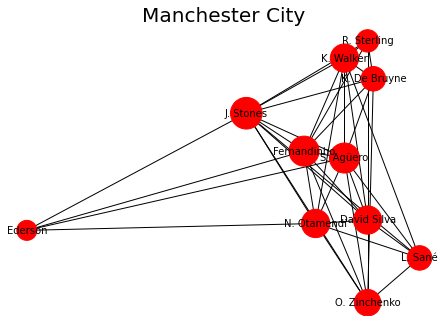

Manchester City
Degree = 80
Centrality = 0.15
Clustering = 0.8
Algebric connectivity = 4.17
Density = 0.73
Diameter = 2
Average Path Length = 1.27


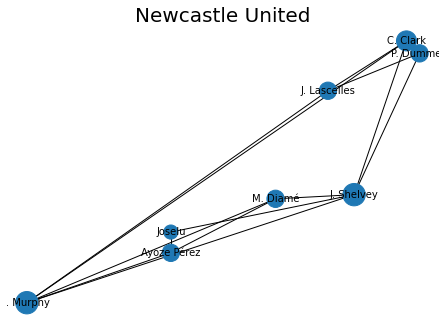

Newcastle United
Degree = 28
Centrality = 0.14
Clustering = 0.46
Algebric connectivity = 1.27
Density = 0.5
Diameter = 3
Average Path Length = 1.57



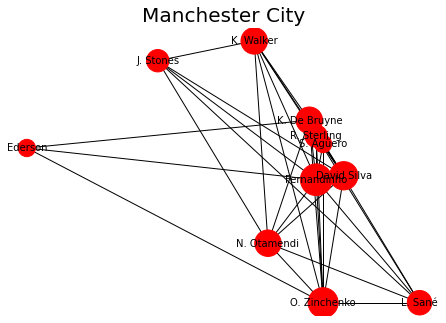

Manchester City
Degree = 70
Centrality = 0.2
Clustering = 0.76
Algebric connectivity = 3.01
Density = 0.64
Diameter = 2
Average Path Length = 1.36


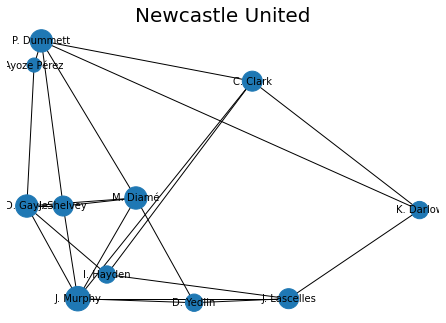

Newcastle United
Degree = 44
Centrality = 0.12
Clustering = 0.3
Algebric connectivity = 1.78
Density = 0.4
Diameter = 3
Average Path Length = 1.65



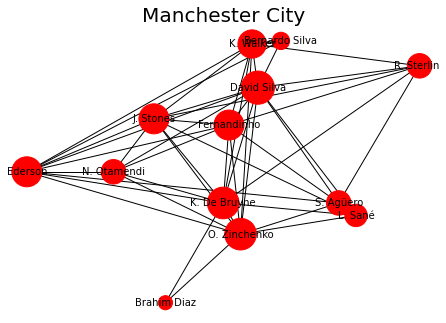

Manchester City
Degree = 94
Centrality = 0.17
Clustering = 0.78
Algebric connectivity = 2.01
Density = 0.6
Diameter = 3
Average Path Length = 1.41


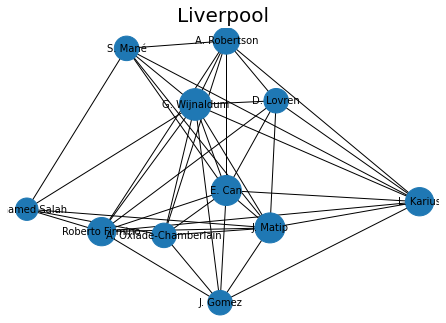

Liverpool
Degree = 80
Centrality = 0.15
Clustering = 0.74
Algebric connectivity = 5.41
Density = 0.73
Diameter = 2
Average Path Length = 1.27



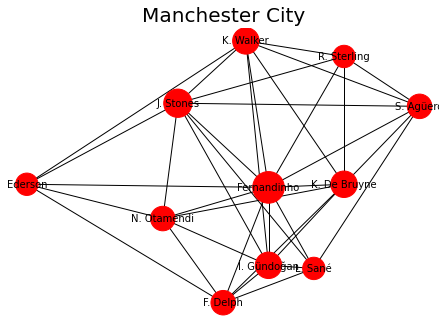

Manchester City
Degree = 72
Centrality = 0.19
Clustering = 0.68
Algebric connectivity = 5.2
Density = 0.65
Diameter = 2
Average Path Length = 1.35


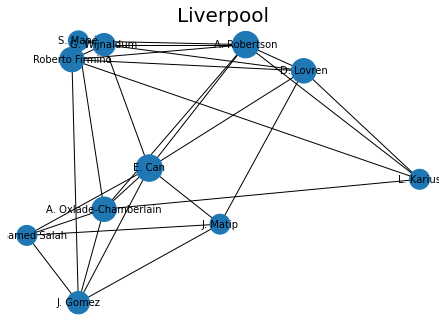

Liverpool
Degree = 58
Centrality = 0.1
Clustering = 0.59
Algebric connectivity = 2.59
Density = 0.53
Diameter = 3
Average Path Length = 1.49



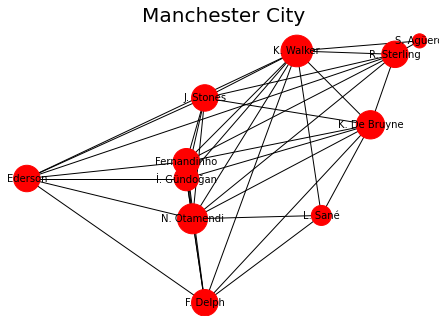

Manchester City
Degree = 74
Centrality = 0.18
Clustering = 0.81
Algebric connectivity = 2.02
Density = 0.67
Diameter = 2
Average Path Length = 1.33


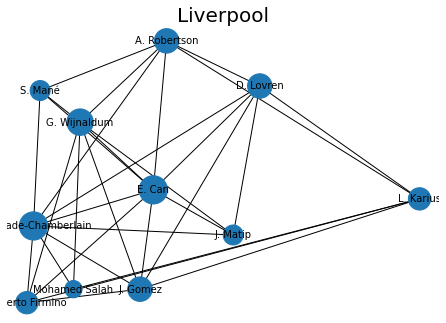

Liverpool
Degree = 62
Centrality = 0.13
Clustering = 0.49
Algebric connectivity = 2.9
Density = 0.56
Diameter = 2
Average Path Length = 1.44



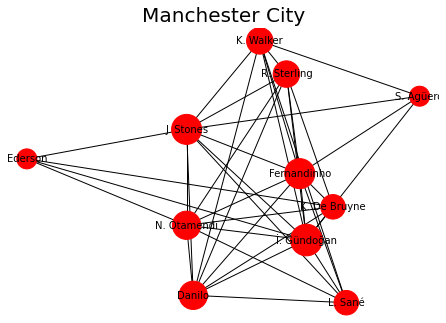

Manchester City
Degree = 78
Centrality = 0.16
Clustering = 0.8
Algebric connectivity = 3.75
Density = 0.71
Diameter = 2
Average Path Length = 1.29


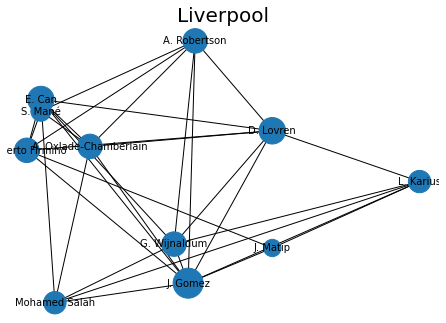

Liverpool
Degree = 64
Centrality = 0.18
Clustering = 0.61
Algebric connectivity = 2.78
Density = 0.58
Diameter = 3
Average Path Length = 1.44



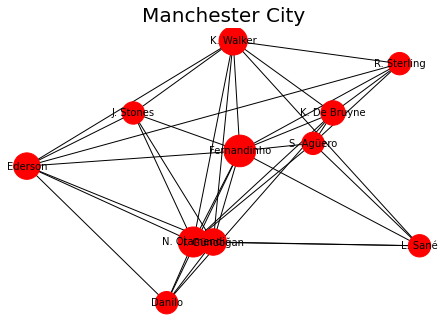

Manchester City
Degree = 72
Centrality = 0.19
Clustering = 0.72
Algebric connectivity = 4.94
Density = 0.65
Diameter = 2
Average Path Length = 1.35


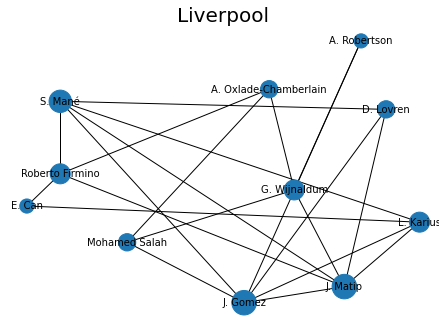

Liverpool
Degree = 42
Centrality = 0.14
Clustering = 0.35
Algebric connectivity = 1.16
Density = 0.38
Diameter = 3
Average Path Length = 1.75



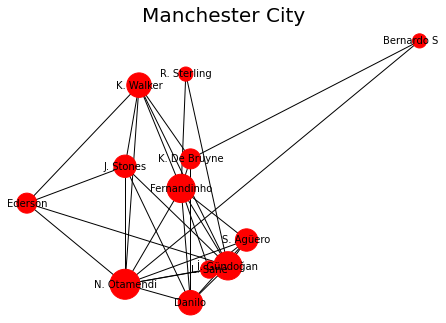

Manchester City
Degree = 62
Centrality = 0.19
Clustering = 0.63
Algebric connectivity = 1.84
Density = 0.47
Diameter = 3
Average Path Length = 1.55


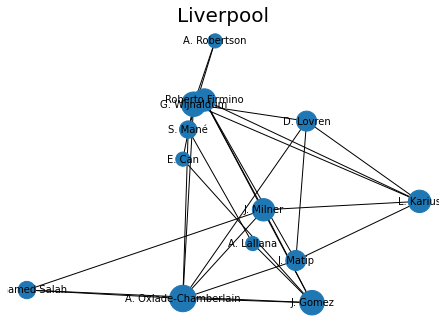

Liverpool
Degree = 54
Centrality = 0.16
Clustering = 0.33
Algebric connectivity = 1.5
Density = 0.35
Diameter = 3
Average Path Length = 1.81



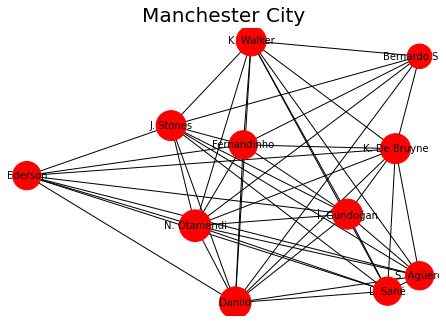

Manchester City
Degree = 94
Centrality = 0.08
Clustering = 0.87
Algebric connectivity = 10.06
Density = 0.85
Diameter = 2
Average Path Length = 1.15


In [8]:
teams_metrics_list = [] 
Total_Winner = []
for idx, match_df in enumerate(matches):
    events_df = events[idx]
    for match_id in match_df.wyId:        
        row = match_df[match_df.wyId == match_id]
        event_df = events_df[events_df.matchId == match_id]
        passing_network(event_df, row, match_id)



In [13]:
data=np.array(teams_metrics_list)

columns = ['Match_Id','Teams','Team_1', 'Team_2', 'T1_Passes','T2_Passes','T1_possession_X','T1_possession_Y','T2_possession_X','T2_possession_Y','T1_degree','T2_degree','T1_Centrality','T2_Centrality','T1_Avg_Cluster','T2_Avg_Cluster','T1_Connectivity','T2_Connectivity','T1_Density','T2_Density','T1_Diameter','T2_Diameter','T1_ASP','T2_ASP']
feature_df = pd.DataFrame(data, columns=columns) 

In [14]:
feature_df.head(12)

,Match_Id,Teams,Team_1,Team_2,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,...,T1_Avg_Cluster,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP
0,2576335,Internazionale-Lazio,Internazionale,Lazio,88,52,45.09,49.45,47.55,46.45,...,0.67,0.68,3.54,3.03,0.62,0.58,2,2,1.38,1.42
1,2576335,Internazionale-Lazio,Internazionale,Lazio,77,39,46.1,52.6,52.0,49.0,...,0.8,0.37,3.7,1.26,0.71,0.4,2,3,1.29,1.71
2,2576335,Internazionale-Lazio,Internazionale,Lazio,89,44,46.18,50.18,40.91,53.09,...,0.83,0.42,2.8,2.48,0.69,0.53,2,3,1.31,1.49
3,2576335,Internazionale-Lazio,Internazionale,Lazio,84,48,48.36,47.18,48.3,36.8,...,0.74,0.48,1.02,1.88,0.62,0.56,3,3,1.42,1.47
4,2576335,Internazionale-Lazio,Internazionale,Lazio,79,46,46.0,42.09,44.36,45.55,...,0.65,0.44,1.78,2.68,0.56,0.49,3,2,1.47,1.51
5,2576335,Internazionale-Lazio,Internazionale,Lazio,59,51,48.17,46.83,39.38,42.92,...,0.63,0.42,1.89,1.63,0.52,0.44,2,3,1.48,1.63
6,2576336,Sassuolo-Roma,Sassuolo,Roma,46,91,42.91,45.36,47.18,51.0,...,0.63,0.78,1.89,2.08,0.53,0.67,3,2,1.49,1.33
7,2576336,Sassuolo-Roma,Sassuolo,Roma,27,68,39.88,40.88,54.2,44.8,...,0.48,0.64,1.75,1.97,0.54,0.53,3,2,1.5,1.47
8,2576336,Sassuolo-Roma,Sassuolo,Roma,50,72,43.45,53.64,41.18,39.82,...,0.54,0.71,2.7,1.81,0.53,0.58,3,3,1.49,1.45
9,2576336,Sassuolo-Roma,Sassuolo,Roma,42,67,44.55,48.82,47.09,59.0,...,0.53,0.66,1.79,3.32,0.51,0.6,3,2,1.53,1.4


### LSTM Implementation

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [16]:
# Converting columns value into integer and floats

feature_df.T1_Passes = feature_df.T1_Passes.apply(lambda x: int(x))
feature_df.T2_Passes = feature_df.T2_Passes.apply(lambda x: int(x))
feature_df.T1_possession_X = feature_df.T1_possession_X.apply(lambda x: float(x))
feature_df.T1_possession_Y = feature_df.T1_possession_Y.apply(lambda x: float(x))
feature_df.T2_possession_X = feature_df.T2_possession_X.apply(lambda x: float(x))
feature_df.T2_possession_Y = feature_df.T2_possession_Y.apply(lambda x: float(x))
feature_df.T1_degree = feature_df.T1_degree.apply(lambda x: int(x))
feature_df.T2_degree = feature_df.T2_degree.apply(lambda x: int(x))
feature_df.T1_Centrality = feature_df.T1_Centrality.apply(lambda x: float(x))
feature_df.T2_Centrality = feature_df.T2_Centrality.apply(lambda x: float(x))
feature_df.T1_Avg_Cluster = feature_df.T1_Avg_Cluster.apply(lambda x: float(x))
feature_df.T2_Avg_Cluster = feature_df.T2_Avg_Cluster.apply(lambda x: float(x))
feature_df.T1_Connectivity = feature_df.T1_Connectivity.apply(lambda x: float(x))
feature_df.T2_Connectivity = feature_df.T2_Connectivity.apply(lambda x: float(x))
feature_df.T1_Density = feature_df.T1_Density.apply(lambda x: float(x))
feature_df.T2_Density = feature_df.T2_Density.apply(lambda x: float(x))
feature_df.T1_Diameter = feature_df.T1_Diameter.apply(lambda x: int(x))
feature_df.T2_Diameter = feature_df.T2_Diameter.apply(lambda x: int(x))
feature_df.T1_ASP = feature_df.T1_ASP.apply(lambda x: float(x))
feature_df.T2_ASP = feature_df.T2_ASP.apply(lambda x: float(x))

In [17]:
feature_df.set_index('Teams', inplace=True)

In [18]:
feature_df

,Match_Id,Team_1,Team_2,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,...,T1_Avg_Cluster,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP
Teams,,,,,,,,,,,,,,,,,,,,,
Internazionale-Lazio,2576335,Internazionale,Lazio,88,52,45.09,49.45,47.55,46.45,68,...,0.67,0.68,3.54,3.03,0.62,0.58,2,2,1.38,1.42
Internazionale-Lazio,2576335,Internazionale,Lazio,77,39,46.10,52.60,52.00,49.00,64,...,0.80,0.37,3.70,1.26,0.71,0.40,2,3,1.29,1.71
Internazionale-Lazio,2576335,Internazionale,Lazio,89,44,46.18,50.18,40.91,53.09,76,...,0.83,0.42,2.80,2.48,0.69,0.53,2,3,1.31,1.49
Internazionale-Lazio,2576335,Internazionale,Lazio,84,48,48.36,47.18,48.30,36.80,68,...,0.74,0.48,1.02,1.88,0.62,0.56,3,3,1.42,1.47
Internazionale-Lazio,2576335,Internazionale,Lazio,79,46,46.00,42.09,44.36,45.55,62,...,0.65,0.44,1.78,2.68,0.56,0.49,3,2,1.47,1.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Saudi Arabia-Russia,2057954,Saudi Arabia,Russia,71,30,40.90,45.40,48.25,50.75,58,...,0.75,0.35,3.42,1.56,0.64,0.36,2,3,1.36,1.71
Saudi Arabia-Russia,2057954,Saudi Arabia,Russia,102,36,44.50,49.00,48.00,48.27,64,...,0.78,0.57,5.22,1.44,0.71,0.40,2,3,1.29,1.65
Saudi Arabia-Russia,2057954,Saudi Arabia,Russia,97,53,41.18,53.09,46.55,47.64,74,...,0.80,0.68,3.84,3.38,0.67,0.64,2,2,1.33,1.36


In [19]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11646 entries, Internazionale-Lazio to Saudi Arabia-Russia
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Match_Id         11646 non-null  object 
 1   Team_1           11646 non-null  object 
 2   Team_2           11646 non-null  object 
 3   T1_Passes        11646 non-null  int64  
 4   T2_Passes        11646 non-null  int64  
 5   T1_possession_X  11646 non-null  float64
 6   T1_possession_Y  11646 non-null  float64
 7   T2_possession_X  11646 non-null  float64
 8   T2_possession_Y  11646 non-null  float64
 9   T1_degree        11646 non-null  int64  
 10  T2_degree        11646 non-null  int64  
 11  T1_Centrality    11646 non-null  float64
 12  T2_Centrality    11646 non-null  float64
 13  T1_Avg_Cluster   11646 non-null  float64
 14  T2_Avg_Cluster   11646 non-null  float64
 15  T1_Connectivity  11646 non-null  float64
 16  T2_Connectivity  11646 non-nul

In [20]:
#Split the data into train and test with the ratio of 75:25

x_train = feature_df[:8700]
y_train = Total_Winner[:1450]

y_test = Total_Winner[1450:]
x_test = feature_df[8700:]



In [101]:
# x = feature_df.iloc[:,3:]
# x
# x_train.iloc[:,3:]

,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,T2_degree,T1_Centrality,T2_Centrality,T1_Avg_Cluster,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP
Teams,,,,,,,,,,,,,,,,,,,,
Internazionale-Lazio,88,52,45.09,49.45,47.55,46.45,68,64,0.15,0.17,0.67,0.68,3.54,3.03,0.62,0.58,2,2,1.38,1.42
Internazionale-Lazio,77,39,46.10,52.60,52.00,49.00,64,44,0.16,0.13,0.80,0.37,3.70,1.26,0.71,0.40,2,3,1.29,1.71
Internazionale-Lazio,89,44,46.18,50.18,40.91,53.09,76,58,0.17,0.10,0.83,0.42,2.80,2.48,0.69,0.53,2,3,1.31,1.49
Internazionale-Lazio,84,48,48.36,47.18,48.30,36.80,68,50,0.16,0.13,0.74,0.48,1.02,1.88,0.62,0.56,3,3,1.42,1.47
Internazionale-Lazio,79,46,46.00,42.09,44.36,45.55,62,54,0.14,0.17,0.65,0.44,1.78,2.68,0.56,0.49,3,2,1.47,1.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Deportivo La Coru\u00f1a-Valencia,68,90,39.09,50.45,49.55,50.55,58,74,0.16,0.12,0.58,0.70,1.00,2.05,0.53,0.67,3,2,1.51,1.33
Deportivo La Coru\u00f1a-Valencia,63,103,51.55,42.82,51.18,48.09,52,76,0.14,0.17,0.44,0.76,0.95,5.31,0.47,0.69,3,2,1.60,1.31
Deportivo La Coru\u00f1a-Valencia,54,74,39.08,46.58,52.64,54.64,54,68,0.19,0.10,0.39,0.58,0.98,2.02,0.41,0.62,3,2,1.67,1.38


In [111]:




# from sklearn import preprocessing
# mm_scaler = preprocessing.MinMaxScaler()
# x_train_temp = mm_scaler.fit_transform(x_train.iloc[:,3:])
# #x_test = mm_scaler.transform(x_test)


ValueError: could not convert string to float: 'Internazionale'

array([[[ 88.  ,  52.  ,  45.09, ...,   2.  ,   1.38,   1.42],
        [ 77.  ,  39.  ,  46.1 , ...,   3.  ,   1.29,   1.71],
        [ 89.  ,  44.  ,  46.18, ...,   3.  ,   1.31,   1.49],
        [ 84.  ,  48.  ,  48.36, ...,   3.  ,   1.42,   1.47],
        [ 79.  ,  46.  ,  46.  , ...,   2.  ,   1.47,   1.51],
        [ 59.  ,  51.  ,  48.17, ...,   3.  ,   1.48,   1.63]],

       [[ 46.  ,  91.  ,  42.91, ...,   2.  ,   1.49,   1.33],
        [ 27.  ,  68.  ,  39.88, ...,   2.  ,   1.5 ,   1.47],
        [ 50.  ,  72.  ,  43.45, ...,   3.  ,   1.49,   1.45],
        [ 42.  ,  67.  ,  44.55, ...,   2.  ,   1.53,   1.4 ],
        [ 69.  ,  66.  ,  55.58, ...,   2.  ,   1.53,   1.39],
        [ 87.  , 110.  ,  46.58, ...,   3.  ,   1.38,   1.39]],

       [[ 42.  ,  99.  ,  40.  , ...,   2.  ,   1.47,   1.29],
        [ 40.  , 127.  ,  46.45, ...,   2.  ,   1.45,   1.3 ],
        [ 42.  ,  98.  ,  43.91, ...,   2.  ,   1.62,   1.29],
        [ 30.  ,  82.  ,  43.09, ...,   2.  ,   1.7

In [21]:
#Conversion of x_train  in the lstm input format

match = x_train.Match_Id.unique()
x_train_lstm = []
for m in match:
    a=x_train[x_train.Match_Id == m][['T1_Passes','T2_Passes','T1_possession_X','T1_possession_Y','T2_possession_X','T2_possession_Y','T1_degree','T2_degree','T1_Centrality','T2_Centrality','T1_Avg_Cluster','T2_Avg_Cluster','T1_Connectivity','T2_Connectivity','T1_Density','T2_Density','T1_Diameter','T2_Diameter','T1_ASP','T2_ASP']].values
    x_train_lstm.append(a)

x_train_lstm_ip = np.array(x_train_lstm)


#Conversion of x_test in the lstm input format

match = x_test.Match_Id.unique()
x_test_lstm = []
for m in match:
    a=x_test[x_test.Match_Id == m][['T1_Passes','T2_Passes','T1_possession_X','T1_possession_Y','T2_possession_X','T2_possession_Y','T1_degree','T2_degree','T1_Centrality','T2_Centrality','T1_Avg_Cluster','T2_Avg_Cluster','T1_Connectivity','T2_Connectivity','T1_Density','T2_Density','T1_Diameter','T2_Diameter','T1_ASP','T2_ASP']].values
    x_test_lstm.append(a)

x_test_lstm_ip = np.array(x_test_lstm)

In [22]:
# change the shape to normalize the data

x_train=x_train_lstm_ip.reshape(1450*6,20)
x_test = x_test_lstm_ip.reshape(491*6,20)

In [23]:

from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [24]:
# Changing the shape back to the desired format of LSTM

x_train_lstm_ip = x_train.reshape(1450,6,20)
x_test_lstm_ip = x_test.reshape(491,6,20)

In [25]:
x_train_lstm_ip

array([[[0.29454545, 0.18257261, 0.52988403, ..., 0.        ,
         0.17605634, 0.22222222],
        [0.25454545, 0.12863071, 0.55240856, ..., 0.25      ,
         0.11267606, 0.40123457],
        [0.29818182, 0.14937759, 0.55419269, ..., 0.25      ,
         0.12676056, 0.2654321 ],
        [0.28      , 0.1659751 , 0.60280999, ..., 0.25      ,
         0.20422535, 0.25308642],
        [0.26181818, 0.15767635, 0.55017841, ..., 0.        ,
         0.23943662, 0.27777778],
        [0.18909091, 0.17842324, 0.5985727 , ..., 0.25      ,
         0.24647887, 0.35185185]],

       [[0.14181818, 0.34439834, 0.48126673, ..., 0.        ,
         0.25352113, 0.16666667],
        [0.07272727, 0.24896266, 0.41369313, ..., 0.        ,
         0.26056338, 0.25308642],
        [0.15636364, 0.26556017, 0.49330955, ..., 0.25      ,
         0.25352113, 0.24074074],
        [0.12727273, 0.24481328, 0.51784121, ..., 0.        ,
         0.28169014, 0.20987654],
        [0.22545455, 0.2406639 , 0.763

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y_train = encoder.transform(y_train)

In [27]:
encoder.fit(y_test)
encoded_Y_test = encoder.transform(y_test)

In [28]:
from keras.utils import np_utils
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

In [29]:
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [30]:
#Conversion of y train and y test

y_train_lstm_ip = dummy_y_train
y_test_lstm_ip = dummy_y_test

In [31]:
y_train_lstm_ip

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [43]:
# create and fit the LSTM network
import random
import keras


seed(0)



model = Sequential()  
model.add(LSTM(20, input_shape=(6, 20)))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
opt = keras.optimizers.adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_lstm_ip, y_train_lstm_ip, validation_data = (x_test_lstm_ip, y_test_lstm_ip), epochs=100, batch_size=1, verbose=1)

Train on 1450 samples, validate on 491 samples
Epoch 1/100
1450/1450 [==============================] - 4s 3ms/step - loss: 1.0907 - accuracy: 0.3662 - val_loss: 1.0736 - val_accuracy: 0.4257
Epoch 2/100
1450/1450 [==============================] - 4s 3ms/step - loss: 1.0872 - accuracy: 0.3745 - val_loss: 1.0697 - val_accuracy: 0.4501
Epoch 3/100
1450/1450 [==============================] - 4s 3ms/step - loss: 1.0820 - accuracy: 0.4055 - val_loss: 1.0669 - val_accuracy: 0.4155
Epoch 4/100
1450/1450 [==============================] - 4s 3ms/step - loss: 1.0768 - accuracy: 0.4234 - val_loss: 1.0615 - val_accuracy: 0.4481
Epoch 5/100
1450/1450 [==============================] - 4s 2ms/step - loss: 1.0682 - accuracy: 0.4379 - val_loss: 1.0532 - val_accuracy: 0.4542
Epoch 6/100
1450/1450 [==============================] - 4s 2ms/step - loss: 1.0470 - accuracy: 0.4800 - val_loss: 1.0414 - val_accuracy: 0.4827
Epoch 7/100
1450/1450 [==============================] - 4s 3ms/step - loss: 1.0208

Epoch 57/100
1450/1450 [==============================] - 4s 3ms/step - loss: 0.8562 - accuracy: 0.6028 - val_loss: 0.9642 - val_accuracy: 0.5662
Epoch 58/100
1450/1450 [==============================] - 4s 3ms/step - loss: 0.8556 - accuracy: 0.6069 - val_loss: 0.9570 - val_accuracy: 0.5703
Epoch 59/100
1450/1450 [==============================] - 4s 3ms/step - loss: 0.8559 - accuracy: 0.6097 - val_loss: 0.9657 - val_accuracy: 0.5540
Epoch 60/100
1450/1450 [==============================] - 4s 3ms/step - loss: 0.8667 - accuracy: 0.6021 - val_loss: 0.9771 - val_accuracy: 0.5458
Epoch 61/100
1450/1450 [==============================] - 4s 3ms/step - loss: 0.8533 - accuracy: 0.6152 - val_loss: 1.0013 - val_accuracy: 0.5703
Epoch 62/100
1450/1450 [==============================] - 4s 3ms/step - loss: 0.8513 - accuracy: 0.6041 - val_loss: 0.9816 - val_accuracy: 0.5540
Epoch 63/100
1450/1450 [==============================] - 4s 3ms/step - loss: 0.8475 - accuracy: 0.6097 - val_loss: 1.0195 -

In [44]:
# Model Train Accuracy

scores = model.evaluate(x_train_lstm_ip, y_train_lstm_ip, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 62.41%


In [45]:
# Model Test Accuracy

scores = model.evaluate(x_test_lstm_ip, y_test_lstm_ip, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Test Accuracy: 56.62%


In [46]:
print(y_test_lstm_ip)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [47]:
#Evaluating test accuracy
from sklearn.metrics import accuracy_score

Y_pred_nn = model.predict(x_test_lstm_ip)
print(Y_pred_nn)
b = np.zeros_like(Y_pred_nn)
b[np.arange(len(Y_pred_nn)), Y_pred_nn.argmax(1)] = 1
b

[[0.13257681 0.83045787 0.03696524]
 [0.05553195 0.00413665 0.9403314 ]
 [0.2883967  0.14286092 0.56874233]
 ...
 [0.28307772 0.07222708 0.6446952 ]
 [0.28103223 0.49733058 0.22163714]
 [0.3217782  0.54133266 0.13688922]]


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [48]:
test_accuracy_nn = accuracy_score(y_test_lstm_ip, b)
print("Test accuracy of Neural Network is " + str(test_accuracy_nn * 100))

Test accuracy of Neural Network is 56.61914460285132


In [49]:
from sklearn.metrics import confusion_matrix
e=y_test_lstm_ip.argmax(1)
f=b.argmax(1)
cm = confusion_matrix(e, f)

cm

array([[ 15,  47,  44],
       [ 17, 129,  40],
       [ 17,  48, 134]], dtype=int64)

In [50]:
from sklearn.metrics import classification_report
print(classification_report(e, f, target_names=['Draw','Team_1','Team_2']))

              precision    recall  f1-score   support

        Draw       0.31      0.14      0.19       106
      Team_1       0.58      0.69      0.63       186
      Team_2       0.61      0.67      0.64       199

    accuracy                           0.57       491
   macro avg       0.50      0.50      0.49       491
weighted avg       0.53      0.57      0.54       491



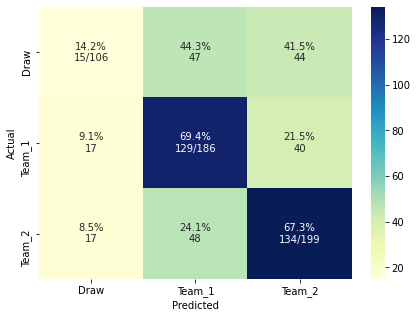

In [51]:
cm = confusion_matrix(e, f, labels=np.unique(e))
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)



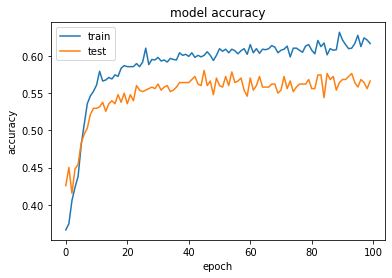

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

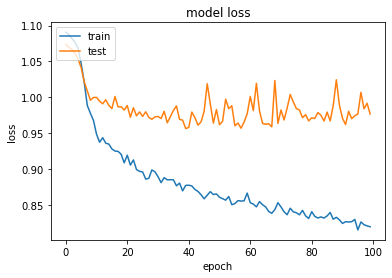

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()